# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Exercise-2.1.-Minimizing-a-quadratic-function-and-the-curse-of-dimensionality" data-toc-modified-id="Exercise-2.1.-Minimizing-a-quadratic-function-and-the-curse-of-dimensionality-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercise 2.1. Minimizing a quadratic function and the curse of dimensionality</a></div><div class="lev1 toc-item"><a href="#Exercise-2.2.-Implementing-random-search-in-Python" data-toc-modified-id="Exercise-2.2.-Implementing-random-search-in-Python-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 2.2. Implementing random search in Python</a></div><div class="lev1 toc-item"><a href="#Exercise-2.3.-Using-random-search-to-minimize-a-nonconvex-function" data-toc-modified-id="Exercise-2.3.-Using-random-search-to-minimize-a-nonconvex-function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise 2.3. Using random search to minimize a nonconvex function</a></div><div class="lev1 toc-item"><a href="#Exercise-2.4.-Random-search-with-diminishing-steplength" data-toc-modified-id="Exercise-2.4.-Random-search-with-diminishing-steplength-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercise 2.4. Random search with diminishing steplength</a></div><div class="lev1 toc-item"><a href="#Exercise-2.5.-Random-descent-probabilities" data-toc-modified-id="Exercise-2.5.-Random-descent-probabilities-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exercise 2.5. Random descent probabilities</a></div><div class="lev1 toc-item"><a href="#Exercise-2.6.-Revisiting-the-curse-of-dimensionality" data-toc-modified-id="Exercise-2.6.-Revisiting-the-curse-of-dimensionality-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exercise 2.6. Revisiting the curse of dimensionality</a></div><div class="lev1 toc-item"><a href="#Exercise-2.7.-Pseudo-code-for-the-coordinate-search-algorithm" data-toc-modified-id="Exercise-2.7.-Pseudo-code-for-the-coordinate-search-algorithm-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exercise 2.7. Pseudo-code for the coordinate search algorithm</a></div><div class="lev1 toc-item"><a href="#Exercise-2.8.-Coordinate-search-applied-to-minimize-a-simple-quadratic" data-toc-modified-id="Exercise-2.8.-Coordinate-search-applied-to-minimize-a-simple-quadratic-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Exercise 2.8. Coordinate search applied to minimize a simple quadratic</a></div><div class="lev1 toc-item"><a href="#Exercise-2.9.-Coordinate-search-with-diminishing-steplength" data-toc-modified-id="Exercise-2.9.-Coordinate-search-with-diminishing-steplength-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Exercise 2.9. Coordinate search with diminishing steplength</a></div><div class="lev1 toc-item"><a href="#Exercise-2.10.-Coordinate-search-versus-coordinate-descent" data-toc-modified-id="Exercise-2.10.-Coordinate-search-versus-coordinate-descent-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Exercise 2.10. Coordinate search versus coordinate descent</a></div>

In [1]:
# imports from custom library
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import autograd.numpy as np

# import custom libraries
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as calib
from mlrefined_libraries import math_optimization_library as optlib

# import demos for this notebook
static_plotter = optlib.static_plotter.Visualizer();
optimizers = optlib.optimizers

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Exercise 2.1. Minimizing a quadratic function and the curse of dimensionality

In this experiment we verify the *curse of dimensionality* issue associated with the use of randomly sampled points for naive evaluation for the simple quadratic function

$$
g(\mathbf{w}) = \mathbf{w}^T\mathbf{w}
$$

whose minimum is always $g(\mathbf{0}_{N\times 1}) = 0$ regardless of the input dimension $N$.

In this experiment we create a range of these quadratics for input dimension $N=1$ to $N = 100$.  We sample the input space of each quadratic $10,000$ times randomly and uniformly on the hypercube $[-1,1]\times [-1,1] \times \cdots \times [-1,1]$ (this hypercube has $N$ sides).  

The printout below shows the *minimum* value attained for each dimensional quadratic after $100$, $1,000$, and $10,000$ samples.  As we can see in the plot, the minimum value attained even after $10,000$ random samples increases substantially as the dimension of the quadratic increases - all due to the curse of dimensionality.  As discussed above we would need to use exponentially many samples to counteract this problem, which quickly becomes infeasible.

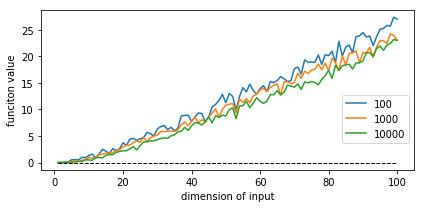

In [46]:
# run experiment for global random evaluation
optlib.random_method_experiments.random_eval_experiment()

A few simple hand-calculations can precisely affirm why this is happening for the particular set of very simple functions we are studying here.  To produce a random point in the input space of the function we sample each axis of the input hypercube  according to a uniform distribution on the interval $[-1,1]$.  Thus the *average value along each input dimension* is equal to 0 (as the average of a uniform on the interval $[a,b]$ is given as $\frac{1}{2}(a+b)$).

The problem is that the probability that all input elements are small in magnitude (close to zero or equal to zero) *simultaneously* gets exponentially smaller as we go up in dimension.  In one dimension, the probability of selecting a value on the interval $[-0.1,0.1]$ is - by definition - $p(v \leq |0.1|) = \frac{0.2}{2} = 0.1$.  However as we go up in dimension since each dimension is drawn independently this means that in $N$ dimensions the probability of drawing each element $v_i$ so that $v_i \leq | 0.1 | $ is $p(v_i \leq |0.1|,\,\, i = 1,...,N) = (0.1)^N$. 

Thus as our dimension increases the probability of randomly accessing points close to the true global minimum at the origin diminishes exponentially.  This again implies that in order to keep up with this our sampling would have to increase exponentially with dimension as well - which is computationally infeasible.

# Exercise 2.2. Implementing random search in Python

Below we have a ``Python`` implementation of the random local search algorithm.  

In [4]:
# random search function
def random_search(g,alpha_choice,max_its,w,num_samples):
    # run random search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        # construct set of random unit directions
        directions = np.random.randn(num_samples,np.size(w))
        norms = np.sqrt(np.sum(directions*directions,axis = 1))[:,np.newaxis]
        directions = directions/norms   
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

Notice that the history of function evaluations returned is called ``cost_history``.  This is because - in the context of machine learning / deep learning - mathematical functions are often referred to as *cost* or *loss* functions.

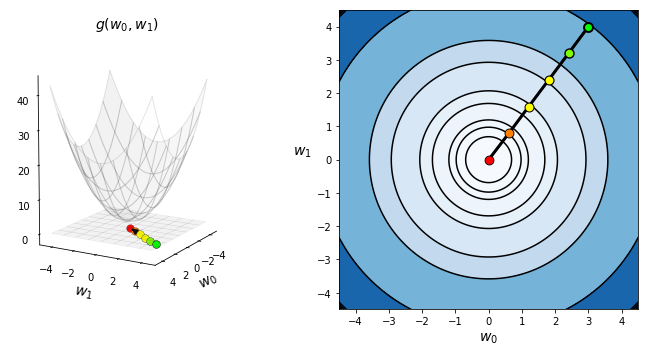

In [5]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history,cost_history = random_search(g,alpha_choice,max_its,w,num_samples)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,view = [10,30],xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5,num_contours = 20)

# Exercise 2.3. Using random search to minimize a nonconvex function

As another example, we minimize the function

\begin{equation}
g(w_0,w_1) = \text{tanh}(4w_0 + 4w_1) + \text{max}(0.4w_0^2,1) + 1
\end{equation}

using random local search again setting $P = 1000$ and 8 steps with $\alpha = 1$ for all steps.  Here because an entire region of global minima exist at $g(w_1,w_2) = 1$ the method - as clumsy as it is given the settings - quickly finds a global minimum when initiated at $\mathbf{w}^0 = \begin{bmatrix} 2 \\ 2 \end{bmatrix}$.

<IPython.core.display.Javascript object>


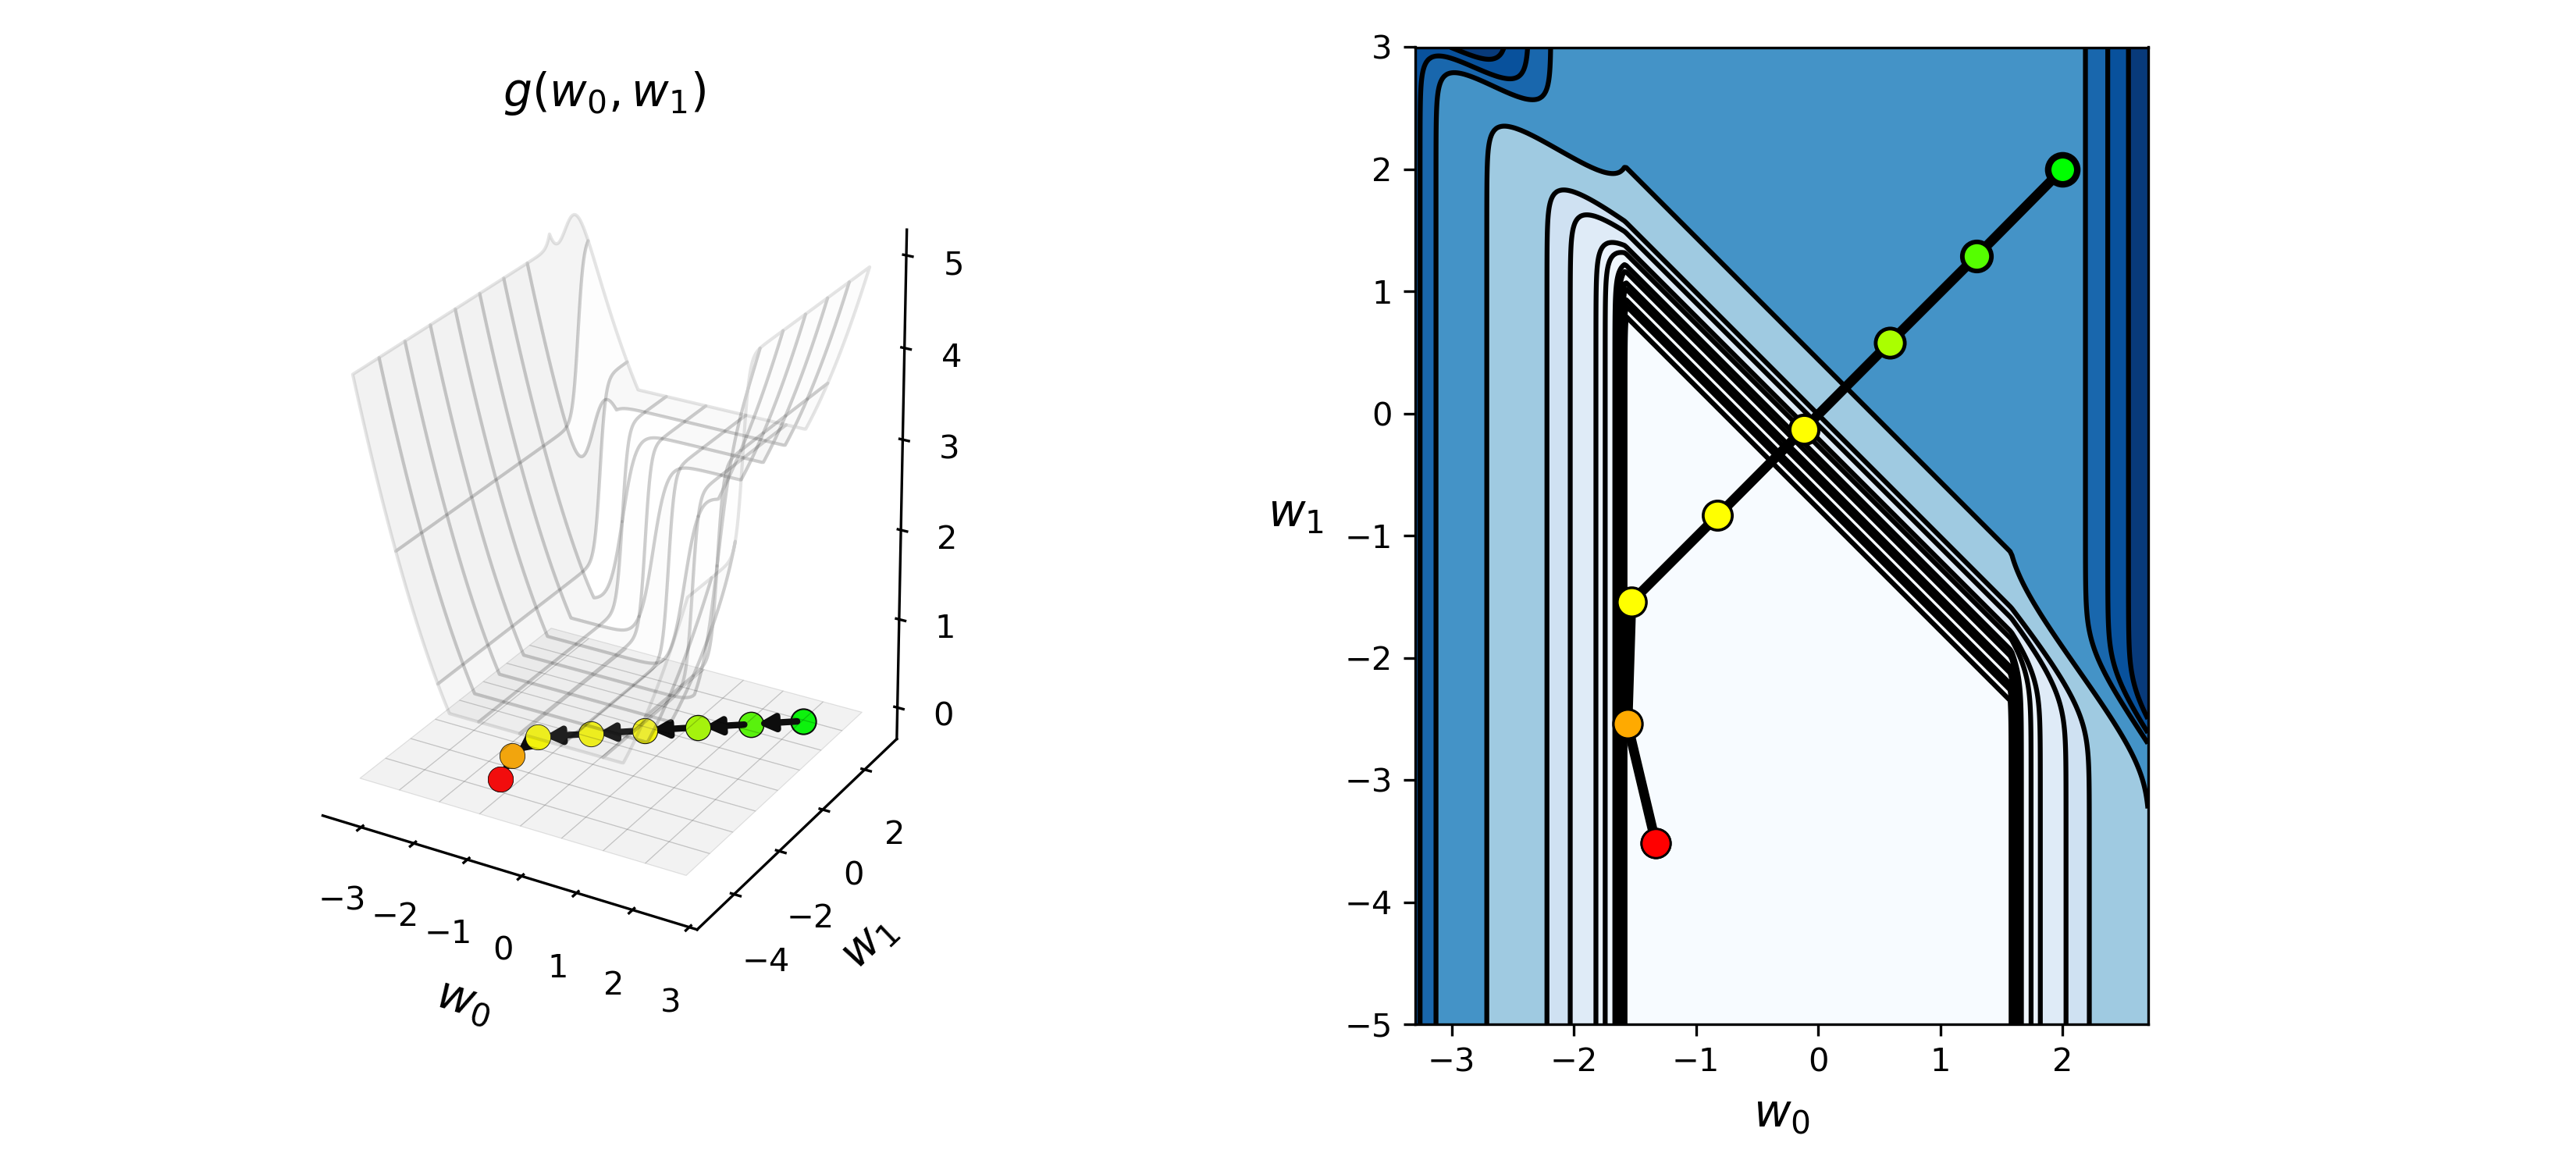

In [6]:
# define function
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(0.4*w[0]**2,1) + 1

# run random search algorithm 
alpha_choice = 1; w = np.array([2,2]); num_samples = 1000; max_its = 8;
weight_history,cost_history = random_search(g,alpha_choice,max_its,w,num_samples)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,view = [20,300],num_contours =30, xmin = -3.3,xmax = 2.7,ymin = -5,ymax = 3)

# Exercise 2.4. Random search with diminishing steplength

In the cell below we make two runs of random search using a famous optimization test function called the *Rosenbrock function* which takes the form

\begin{equation}
g\left(w_0,w_1\right) = 100\left(w_1 - w_0^2\right)^2 + \left(w_0 - 1\right)^2.
\end{equation}

This function (whose contour plot is shown in the left panel below) has a global minimum at the point $\mathbf{w}^{\star} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$ located in a very narrow and curved valley.

With both runs we begin at the point $\mathbf{w} = \begin{bmatrix} -2 \\ -2 \end{bmatrix}$, examine 1000 sample directions per step, and take a maximum of 50 steps.  First - as illustrated below - we use a fixed steplength value $\alpha = 1$.  We can see that the procedure halts after just 5 steps because every direction stemming from the final point of length one is an ascent direction.  The method was able to enter the long curved narrow valley where the mininum is located, but cannot properly navigate inside it because the steplength value is too large.

<IPython.core.display.Javascript object>


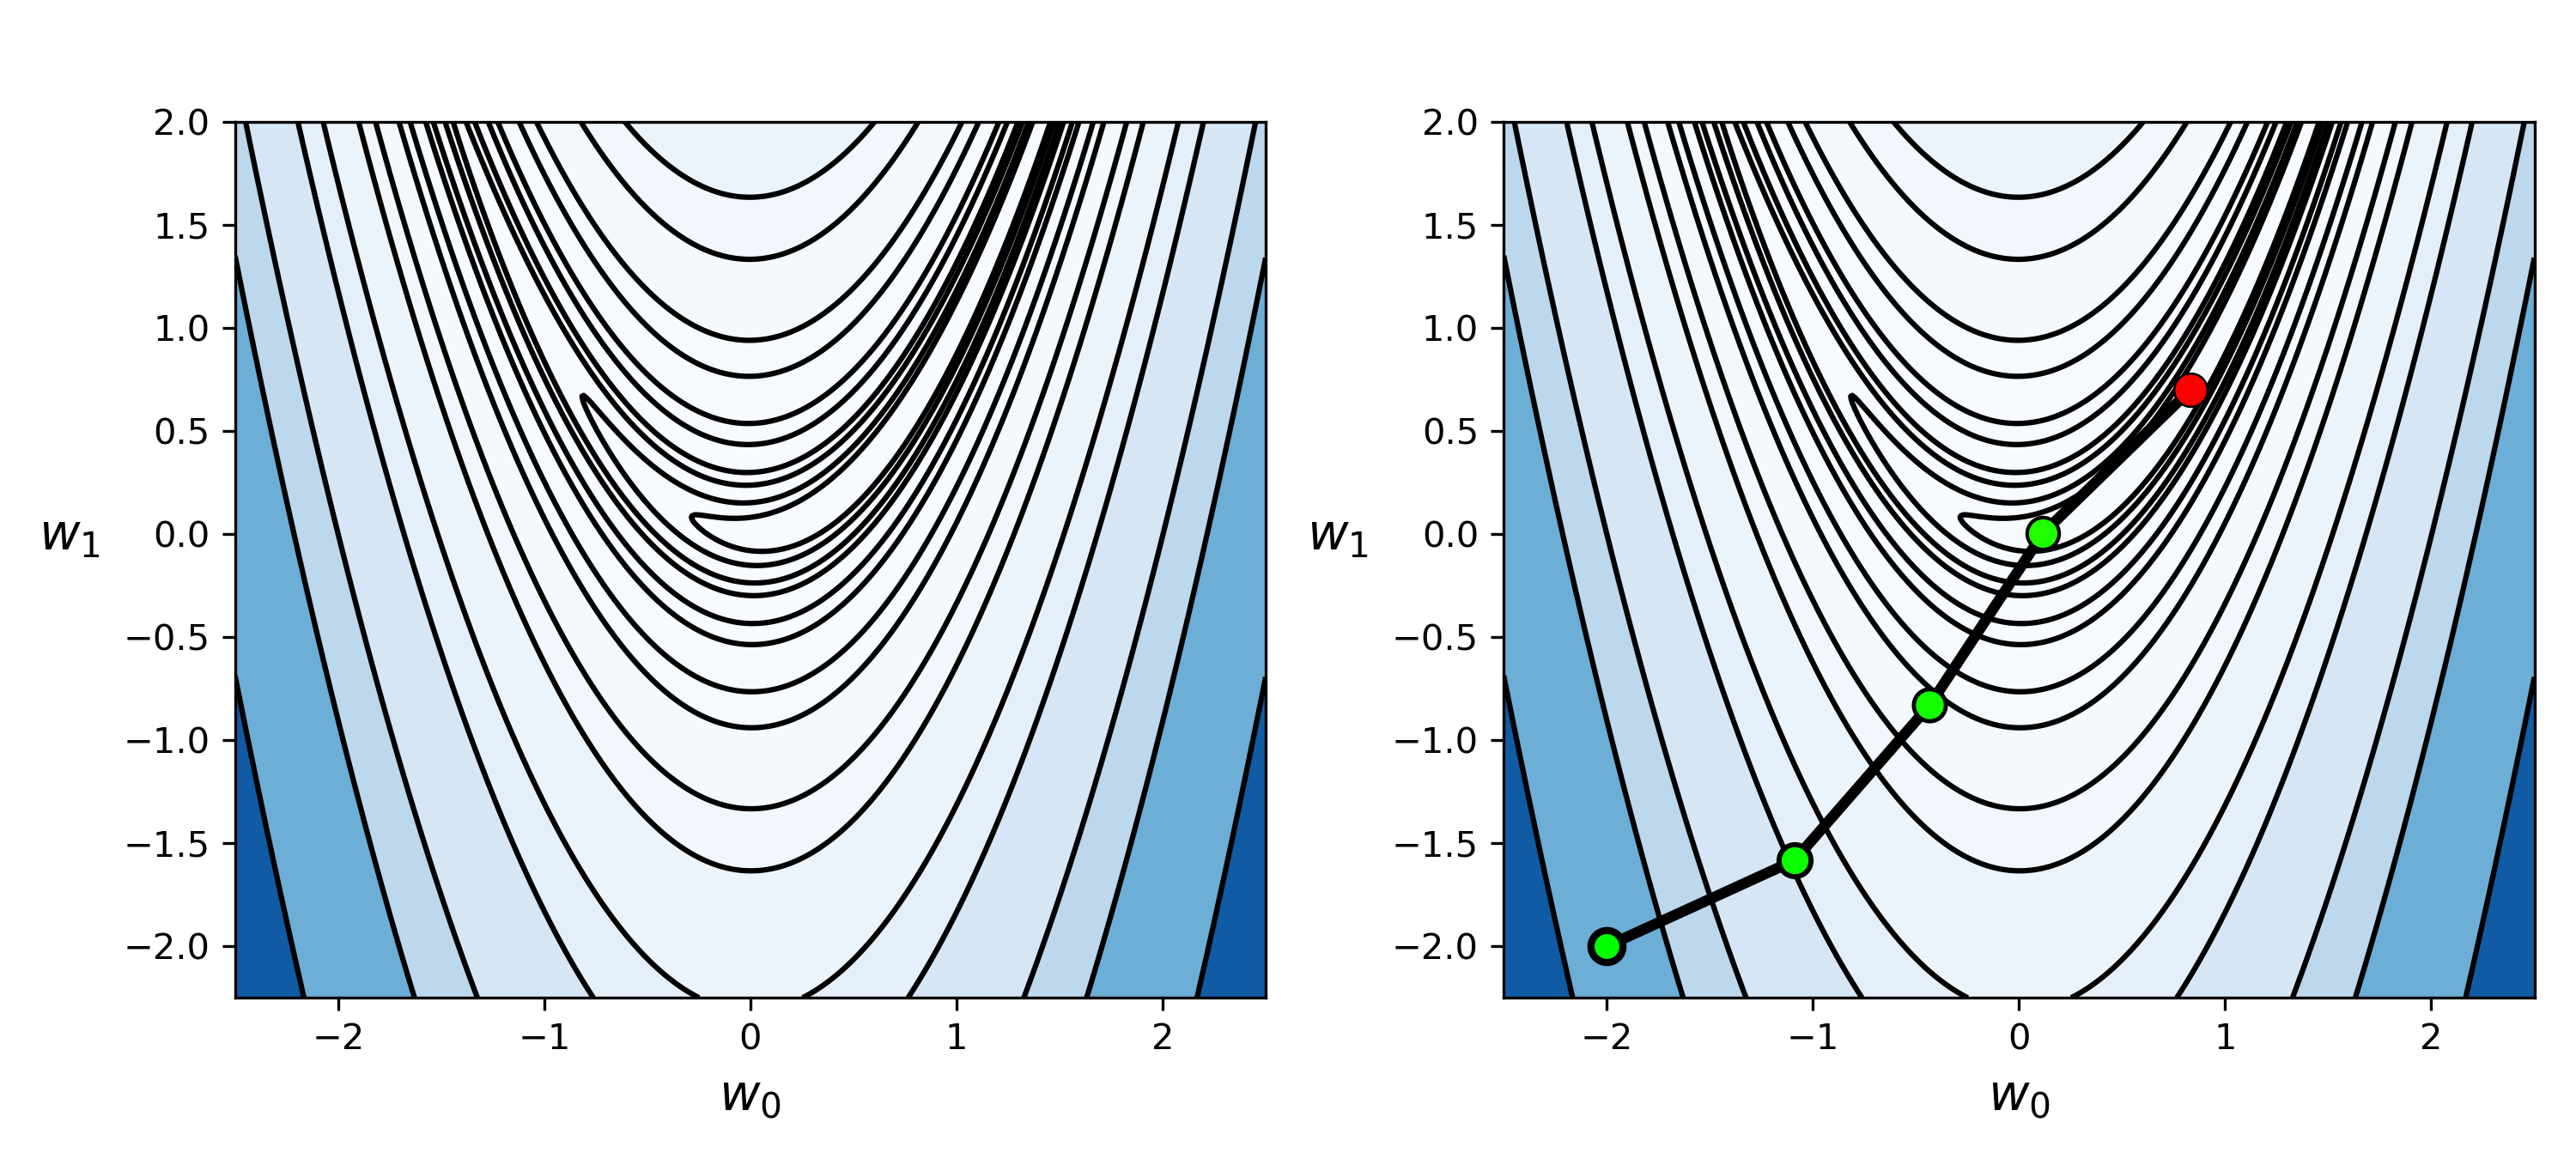

In [7]:
# define function
g = lambda w: 100*(w[1] - w[0]**2)**2 + (w[0] - 1)**2 

# run random search algorithm 
alpha_choice = 1; w = np.array([-2,-2]); num_samples = 1000; max_its = 50;
weight_history_1,cost_history_1 = random_search(g,alpha_choice,max_its,w,num_samples)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history_1,num_contours = 35,xmin = -2.5,xmax = 2.5,ymin = -2.25,ymax = 2)

Now we make the same run but use the diminishing steplength rule $\alpha = \frac{1}{k}$.  Because the steplength is constantly shortened the procedure never encounters a problem like the run above, and completes all 50 iterations.  More importantly the diminishing steplength allows this local method to better navigate the long narrow valley that contains the global mininum - and so can get substantially closer to it than can a run with a fixed steplength value.  Below make this run, plotting the original fixed steplength run in the left panel and the run produced with the diminishing steplength rule in the right panel.

In [8]:
# define function
g = lambda w: 100*(w[1] - w[0]**2)**2 + (w[0] - 1)**2 

# run random search algorithm 
alpha_choice = 'diminishing'; w = np.array([-2,-2]); num_samples = 1000; max_its = 50;
weight_history_2,cost_history_2 = random_search(g,alpha_choice,max_its,w,num_samples)

<IPython.core.display.Javascript object>


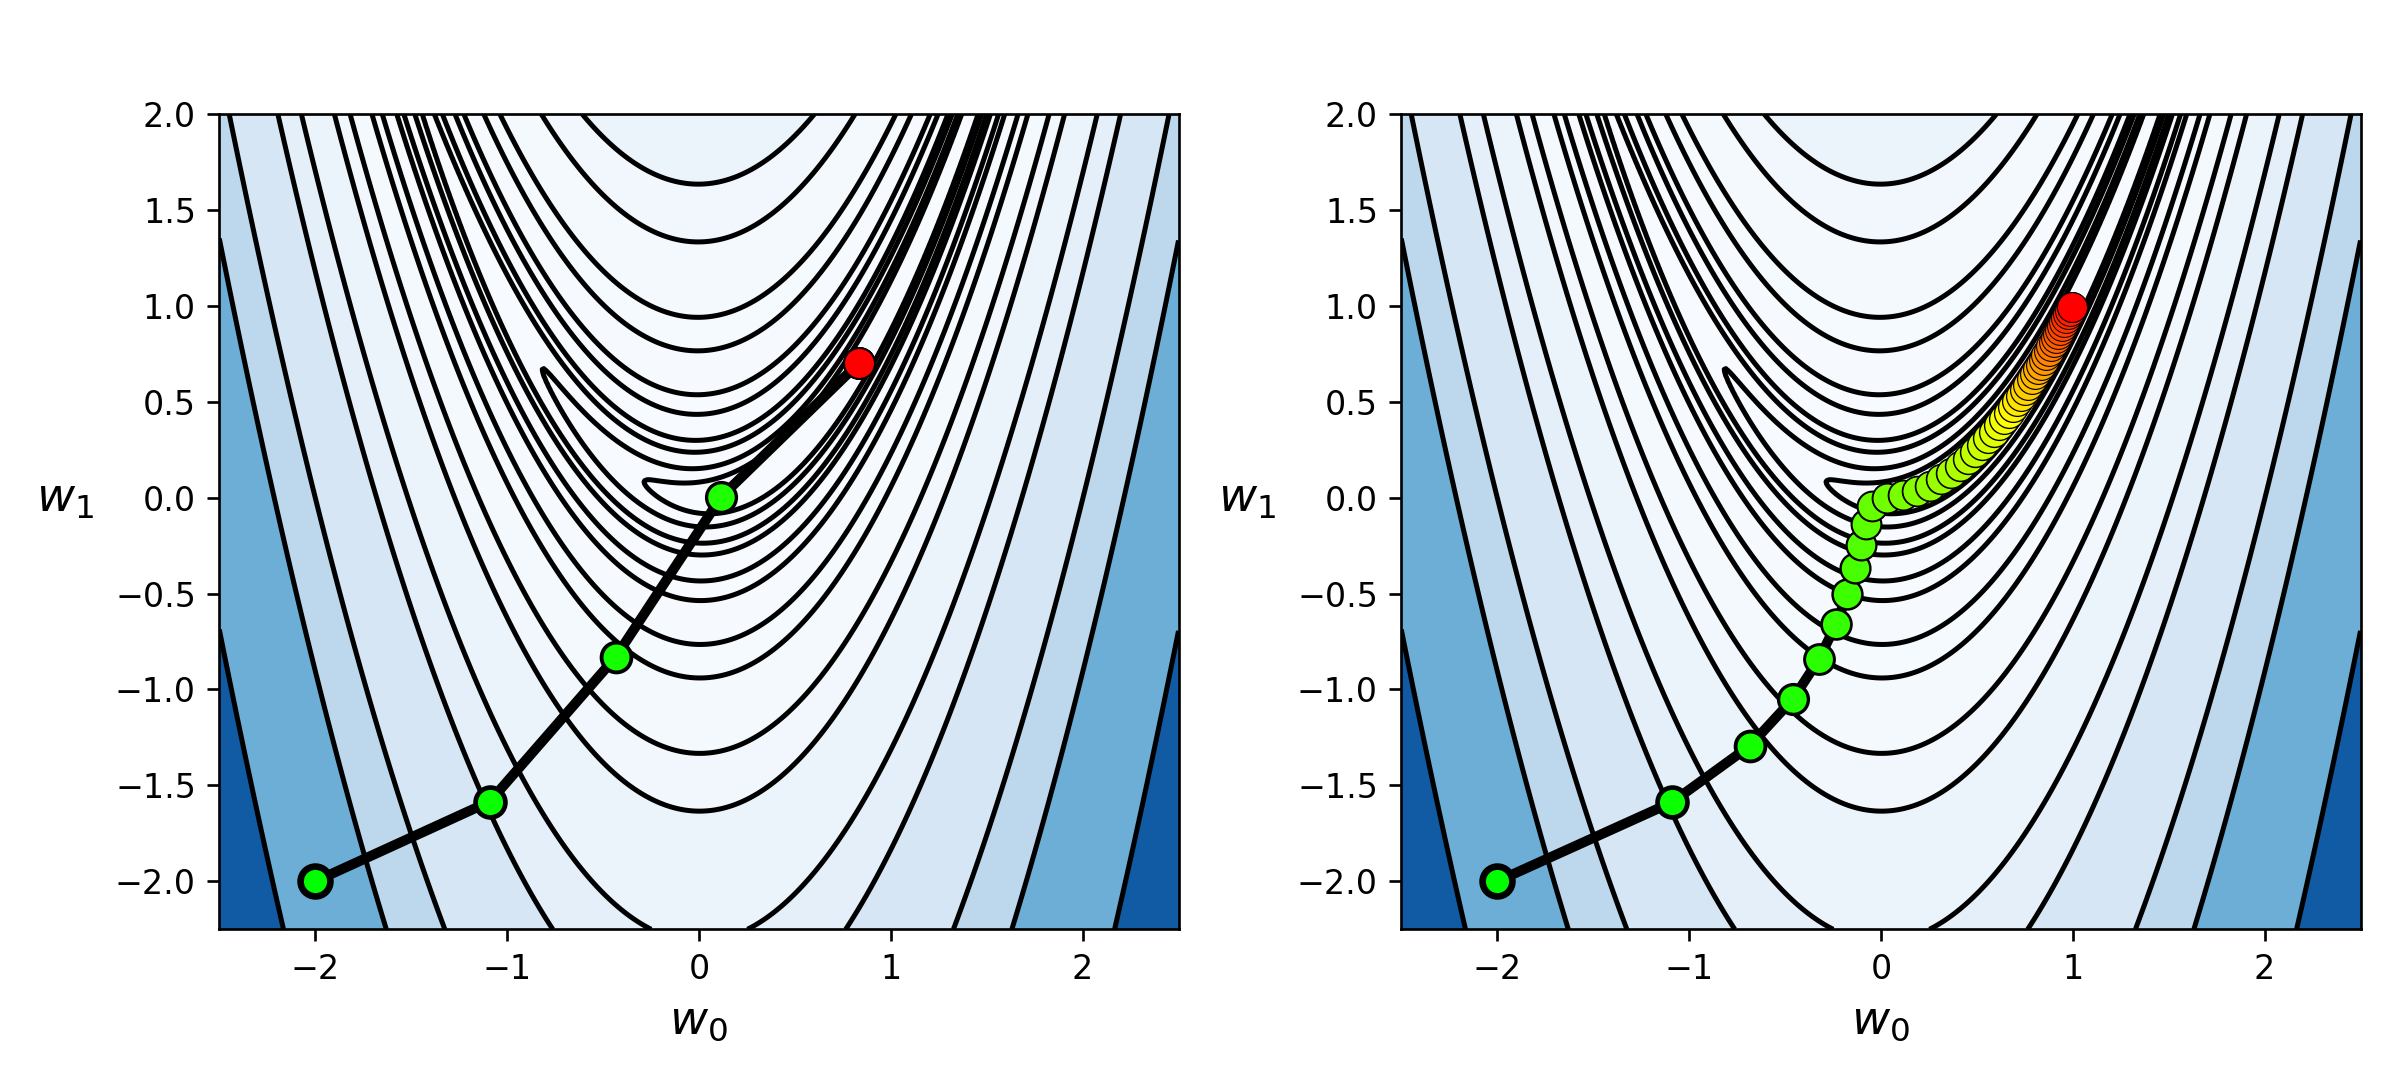

In [9]:
# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],num_contours = 35,xmin = -2.5,xmax = 2.5,ymin = -2.25,ymax = 2,show_original = False)

# Exercise 2.5. Random descent probabilities

As with the global optimization approach, the curse of dimensionality also poses a major obstacle to random local search as the dimension of a function's input increases. We illustrate this using a sequence of simple quadratic functions (where we will gradually increase the input dimension $N$)

\begin{equation}
g\left(\mathbf{w}\right)=\mathbf{w}^{T}\mathbf{w}+2
\end{equation}

starting at the point 

\begin{equation}
\mathbf{w}^{0}=\left[\begin{array}{c}
1\\
0\\
0\\
\vdots\\
0
\end{array}\right]_{ N\times1}
\end{equation} 

a) When $N=2$, starting at $\mathbf{w}^{0}=\left[\begin{array}{cc}
1 \\ 0\end{array}\right]$ (shown by a blue circle in the figure below) we have infinitely many unit directions to choose from, where only a fraction of them whose endpoint lie inside the unit circle (centered at origin) are descent directions. Therefore if we were to choose a unit direction randomly, the descent probability would be calculated as the length of the yellow arc in the figure divided by the entire length of the unit circle centered at $\mathbf{w}^{0}$.

\begin{equation}
\text{descent probability}=\frac{\text{length of yellow arc}}{\text{length of unit circle}}
\end{equation}

For more clarity, the two-dimensional input space is re-drawn from above in the right panel of the figure below.

<p>
<img src= 'img/hypersphere_2d.png' width="100%" height="150%"/>
</p>

Notice the black circle shown in the right panel, centered at the midpoint of $\mathbf{w}^{0}$ and the origin, completely encompasses the yellow arc, and hence one-half of its length is greater than that of the yellow arc. In other words, the length of the yellow arc is upper-bounded by the length of the black semi-circle that lie inside the unit circle, and we have  

\begin{equation}
\text{descent probability}<\frac{1}{2}\cdot\frac{\text{length of black circle}}{\text{length of unit circle}}
\end{equation}

Both the numerator and the denominator are now easy to compute, noticing that a simple application of the Pythagorean theorem gives the radius of the black circle as $\frac{\sqrt{3}}{2}$.

\begin{equation}
\text{descent probability}<\frac{1}{2}\cdot\frac{2\pi\left(\frac{\sqrt{3}}{2}\right)}{2\pi\left(1\right)}=\frac{\sqrt{3}}{4}=0.433
\end{equation}

b) In higher dimensions we can still use the same geometric argument we made above to find an upperbound to the descent probability, only this time we are dealing with hyperspheres instead of circles. More specifically, in $N$ we can write  

\begin{equation}
\text{descent probability}<\frac{1}{2}\cdot\frac{\text{surface area of encompassing hypersphere of radius } \frac{\sqrt{3}}{2}}{\text{surface area of unit hypersphere}}=\frac{1}{2}\cdot\left(\frac{\sqrt{3}}{2}\right)^{N-1}
\end{equation}

So, for instance, when $N=30$ the descent probability falls below 1%. 

# Exercise 2.6. Revisiting the curse of dimensionality

Here we empirically confirm the curse of dimensionality problem described above for the simple quadratic used there.  In the Python cell below we gradually increase the dimension of the input to this quadratic from $N = 1$ to $N = 25$, and starting at the $N$ dimensional input point $\mathbf{w}^{0}=\left[\begin{array}{cc}
1 \\ 0 \\ \vdots \\ 0\end{array}\right]$ we create $10,000$ random unit directions and evaluate candidate point $\mathbf{w}_{\text{candidate}} = \mathbf{w}^0 - \mathbf{d}$ - where $\mathbf{d}$ is a random unit direction - via the quadratic.

The printout shows what portion of the sampled directions provide a decrease in function evaluation - or in other words what portion of those sampled are descent directions - among the first $100$, $1,000$, and $10,000$ directions sampled.  As we can see from the printout this portion vanishes rapidly to zero as $N$ increases, even when $10,000$ random directions are chosen.

<IPython.core.display.Javascript object>


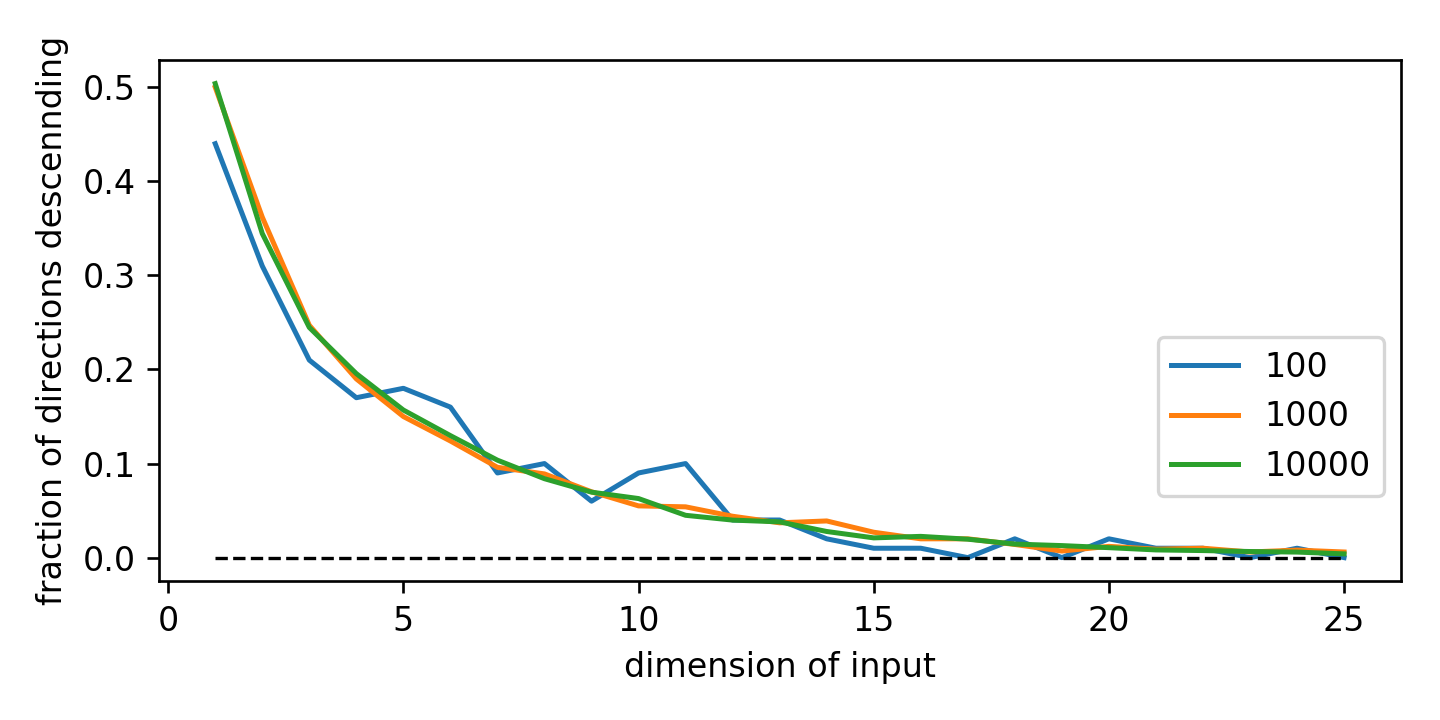

In [10]:
# run experiment
optlib.random_method_experiments.random_local_experiment()

The true global minimum here is located at $(w_1,w_2) = (0,0)$, which we do not get that close too in the above run.  However if we increase both the number of directions sampled at each step $P$ as well as the number of total iterations we can get closer.  We do this in the next Python cell - increasing $P = 100$ and letting the maximum number of iterations equal 10.

# Exercise 2.7. Pseudo-code for the coordinate search algorithm

Below we provide both pseudo-code and an implementation of coordinate search, followed by several examples employing it.

![title](img/pseudo_code.png)

# Exercise 2.8. Coordinate search applied to minimize a simple quadratic

Below we implement the coordinate search algorithm.

In [11]:
# zero order coordinate search
def coordinate_search(g,alpha_choice,max_its,w):
    # construct set of all coordinate directions
    directions_plus = np.eye(np.size(w),np.size(w))
    directions_minus = - np.eye(np.size(w),np.size(w))
    directions = np.concatenate((directions_plus,directions_minus),axis=0)
        
    # run coordinate search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

In the next Python cell we compare 5 steps of the random search algorithm (with $P = 1000$ random directions tested at each step) to 7 steps of coordinate search, using the same starting point $\mathbf{w}^0 = \begin{bmatrix}3 \\ 4\end{bmatrix}$ and fixed steplength parameter value $\alpha = 1$ for both.  The test function in this case is the simple quadratic used in several of the examples of the previous Section

\begin{equation}
g(w_0,w_1) = w_0^2 + w_1^2 + 2.
\end{equation}

The resulting steps taken by random search are shown on the function contour in the left panel, and likewise for coordinate search in the right panel.  Both algorithms reach the global minimum of the function at the origin, but it takes coordinate search a few more steps to do so (due to the vastly fewer directions it searches over when compared to random search).  Notice as well how the steps of coordinate descent tend to zig-zag towards the solution.  This is again due to the fact that it only looks over the two perpendicular directions provided by the axes when deciding on a direction for each step.

<IPython.core.display.Javascript object>


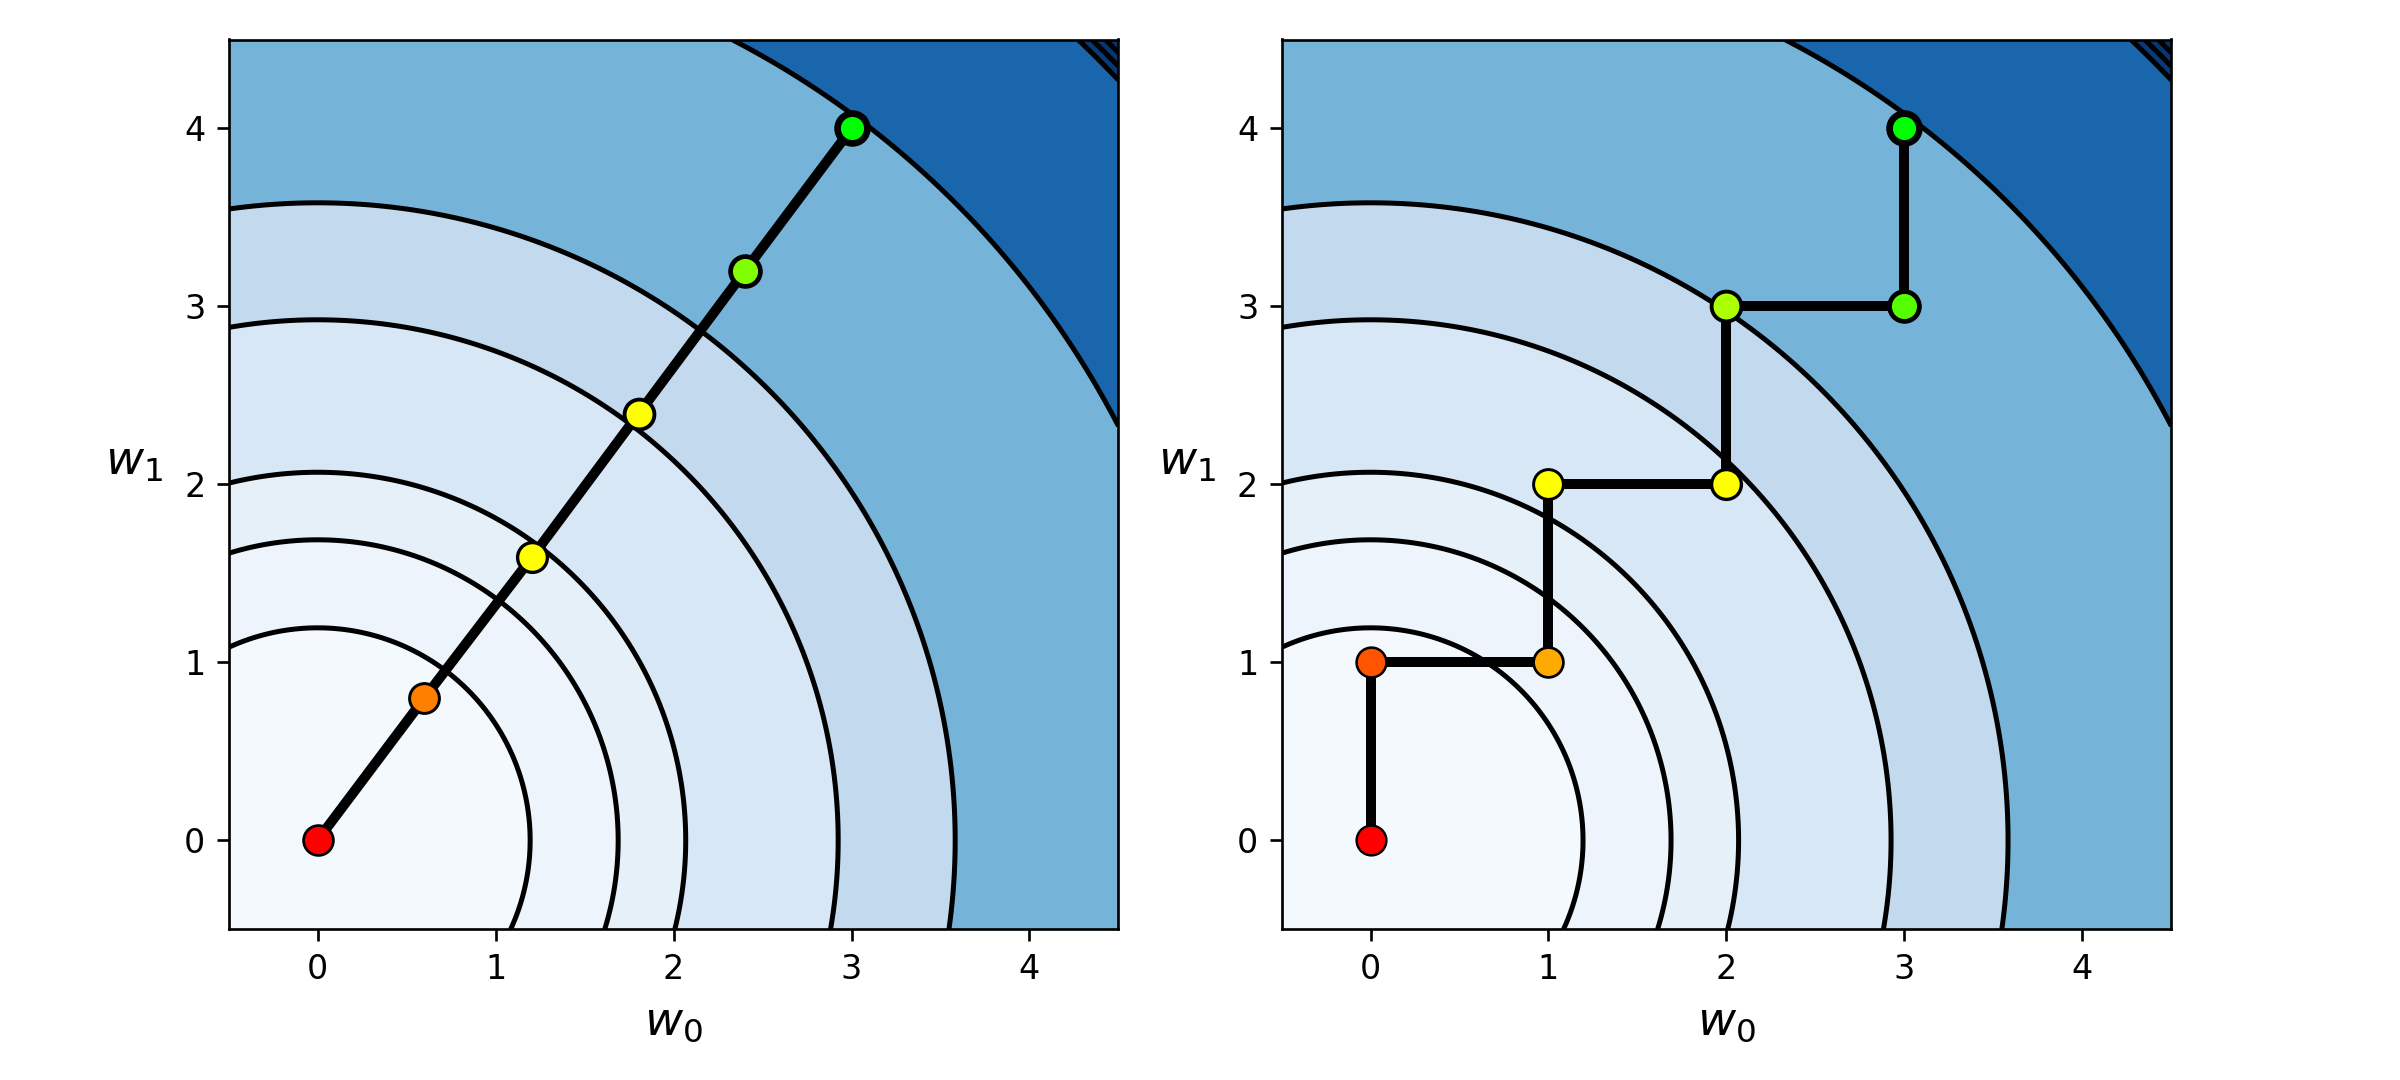

In [12]:
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history_1,cost_history_1 = optimizers.random_search(g,alpha_choice,max_its,w,num_samples)

# run coordinate search algorithm 
alpha_choice = 1; w = np.array([3,4]); max_its = 7;
weight_history_2,cost_history_2 = coordinate_search(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -0.5,xmax = 4.5,ymin = -0.5,ymax = 4.5,num_contours = 17)

# Exercise 2.9. Coordinate search with diminishing steplength

In the next Python cell we compare 5 steps of the random search algorithm (with $P = 1000$ random directions tested at each step) to 5 steps of coordinate search, using the same starting point $\mathbf{w}^0 = \begin{bmatrix}3 \\ 4\end{bmatrix}$ and fixed steplength parameter value $\alpha = 1$ for both.  The test function in this case is a skewed quadratic function

\begin{equation}
g(w_0,w_1) = 0.26\left(w_0^2 + w_1^2\right) - 0.48w_0w_1
\end{equation}

The resulting steps taken by random search are shown on the function contour in the left panel, and likewise for coordinate search in the right panel.  Here while the random search algorithm finds the true minimum at the origin, the coordinate search run halts after the first step due to the steplength being set too large for this particular function / initialization (each of the four coordinate directions are directions of *ascent* at the first step).

<IPython.core.display.Javascript object>


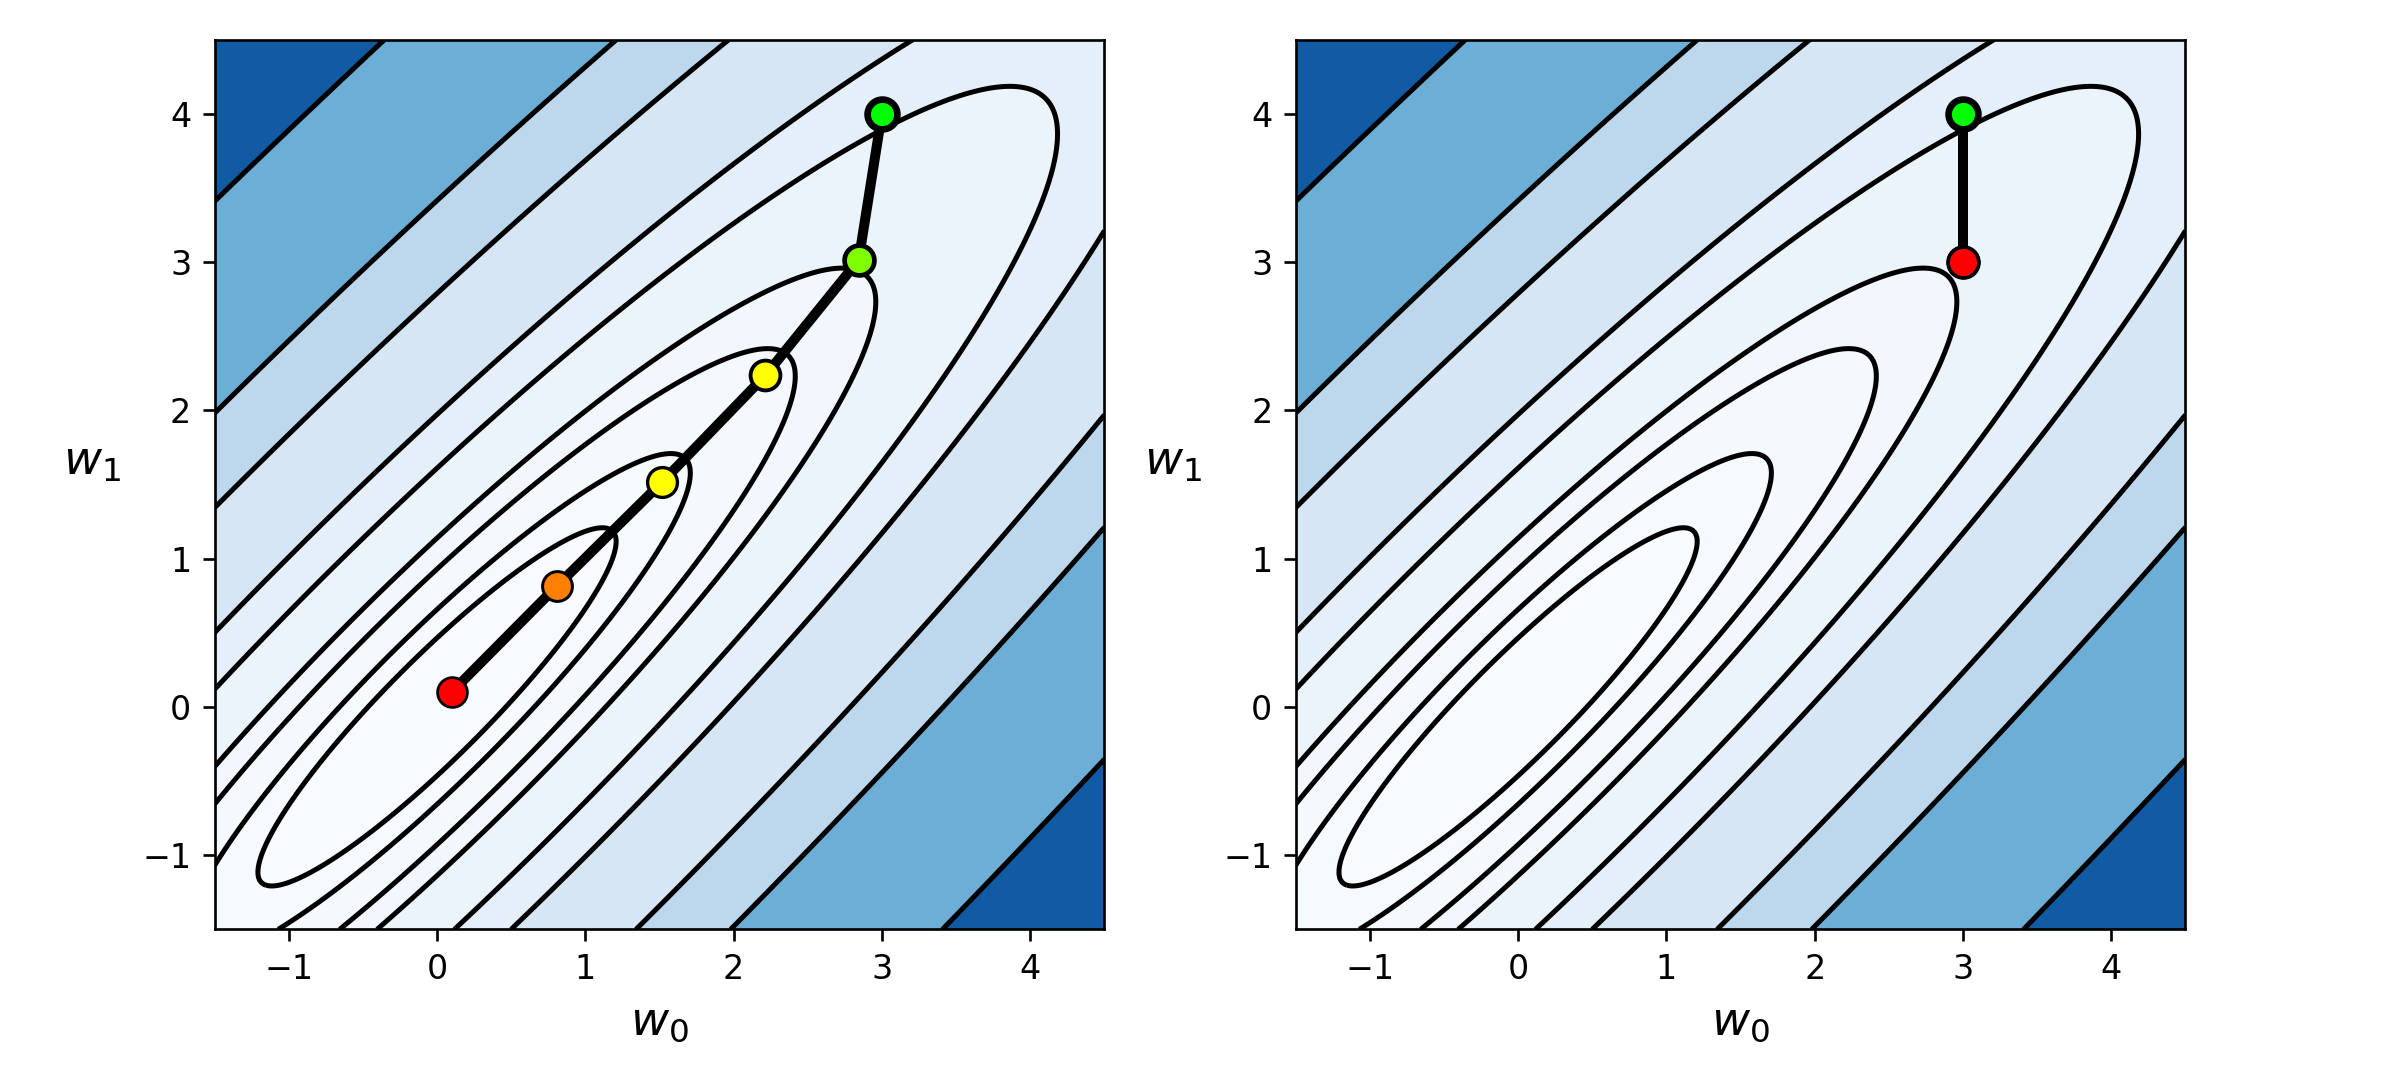

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history_1,cost_history_1 = optimizers.random_search(g,alpha_choice,max_its,w,num_samples)

# run coordinate search algorithm 
alpha_choice = 1; w = np.array([3,4]); max_its = 5;
weight_history_2,cost_history_2 = coordinate_search(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 23)

By making the steplength parameter smaller we can encourage coordinate search to find its way towards the function's minimum at the origin.  Below we re-run coordinate search using a diminishing steplength parameter $\alpha = \frac{1}{k}$ at the $k^{th}$ step for $1000$ steps.  With this run the method gets much closer to the function minimum.  Furthermore, even though we used $1000$ steps this run takes fewer total function evaluations - and hence total computation - then the corresponding random search run shown above (for the simple reason discussed in the previous example).

<IPython.core.display.Javascript object>


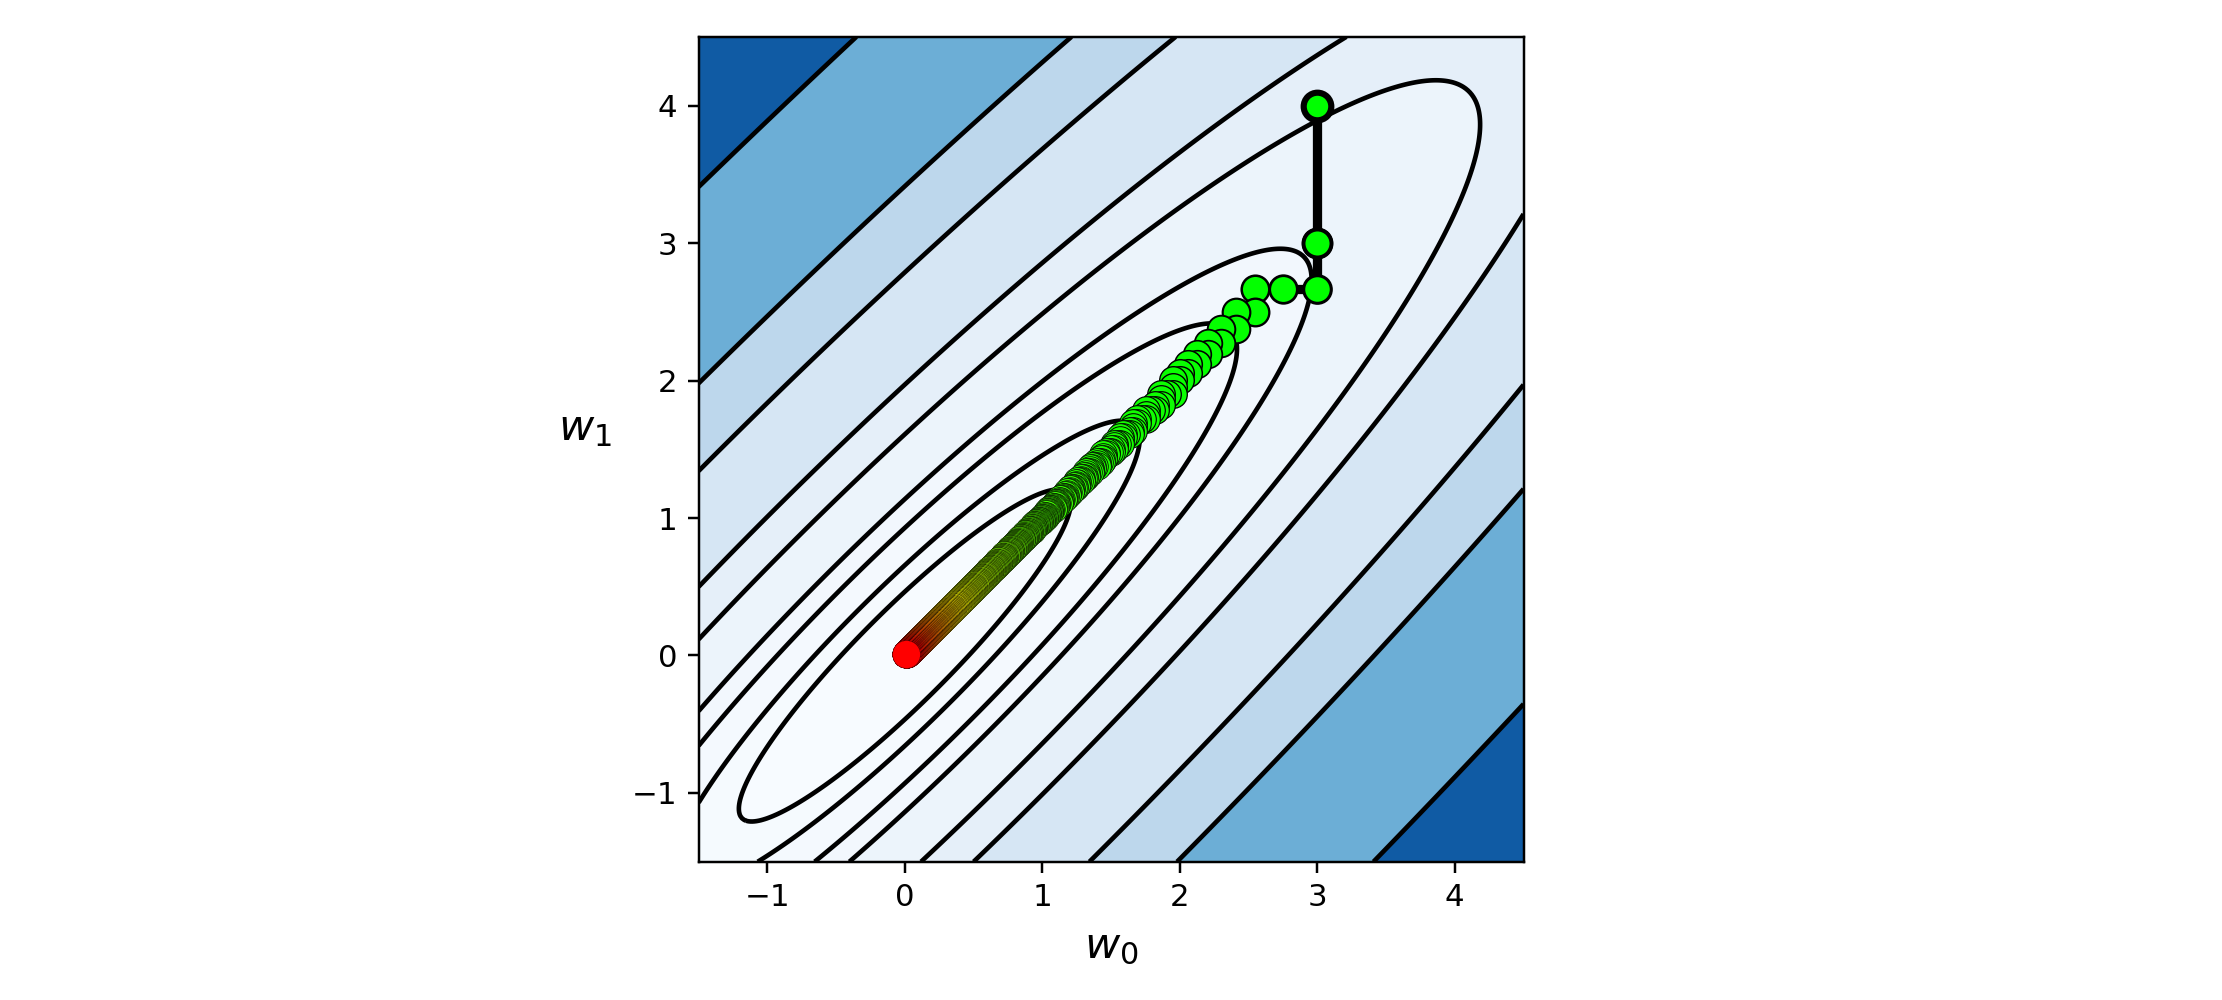

In [14]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 1000;
weight_history,cost_history = coordinate_search(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 23,show_original = False)

# Exercise 2.10. Coordinate search versus coordinate descent

In [22]:
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the dirction matrix out of the loop
        cost = g(w)
        
        # loop over each coordinate direction
        for n in range(N):
            direction = np.zeros((N,1)).flatten()
            direction[c[n]] = 1
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction)]
            evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

In this example we compare the efficacy of coordinate search and the coordinate descent algorithm described above using the same function from the previous example.  Here we compare $20$ steps of coordinate search (left panel) and coordinate descent (right panel), using a diminishing step length for both runs.  Because coordinate descent takes two steps for every single step taken by coordinate search we get significantly closer to the function minimum.

<IPython.core.display.Javascript object>


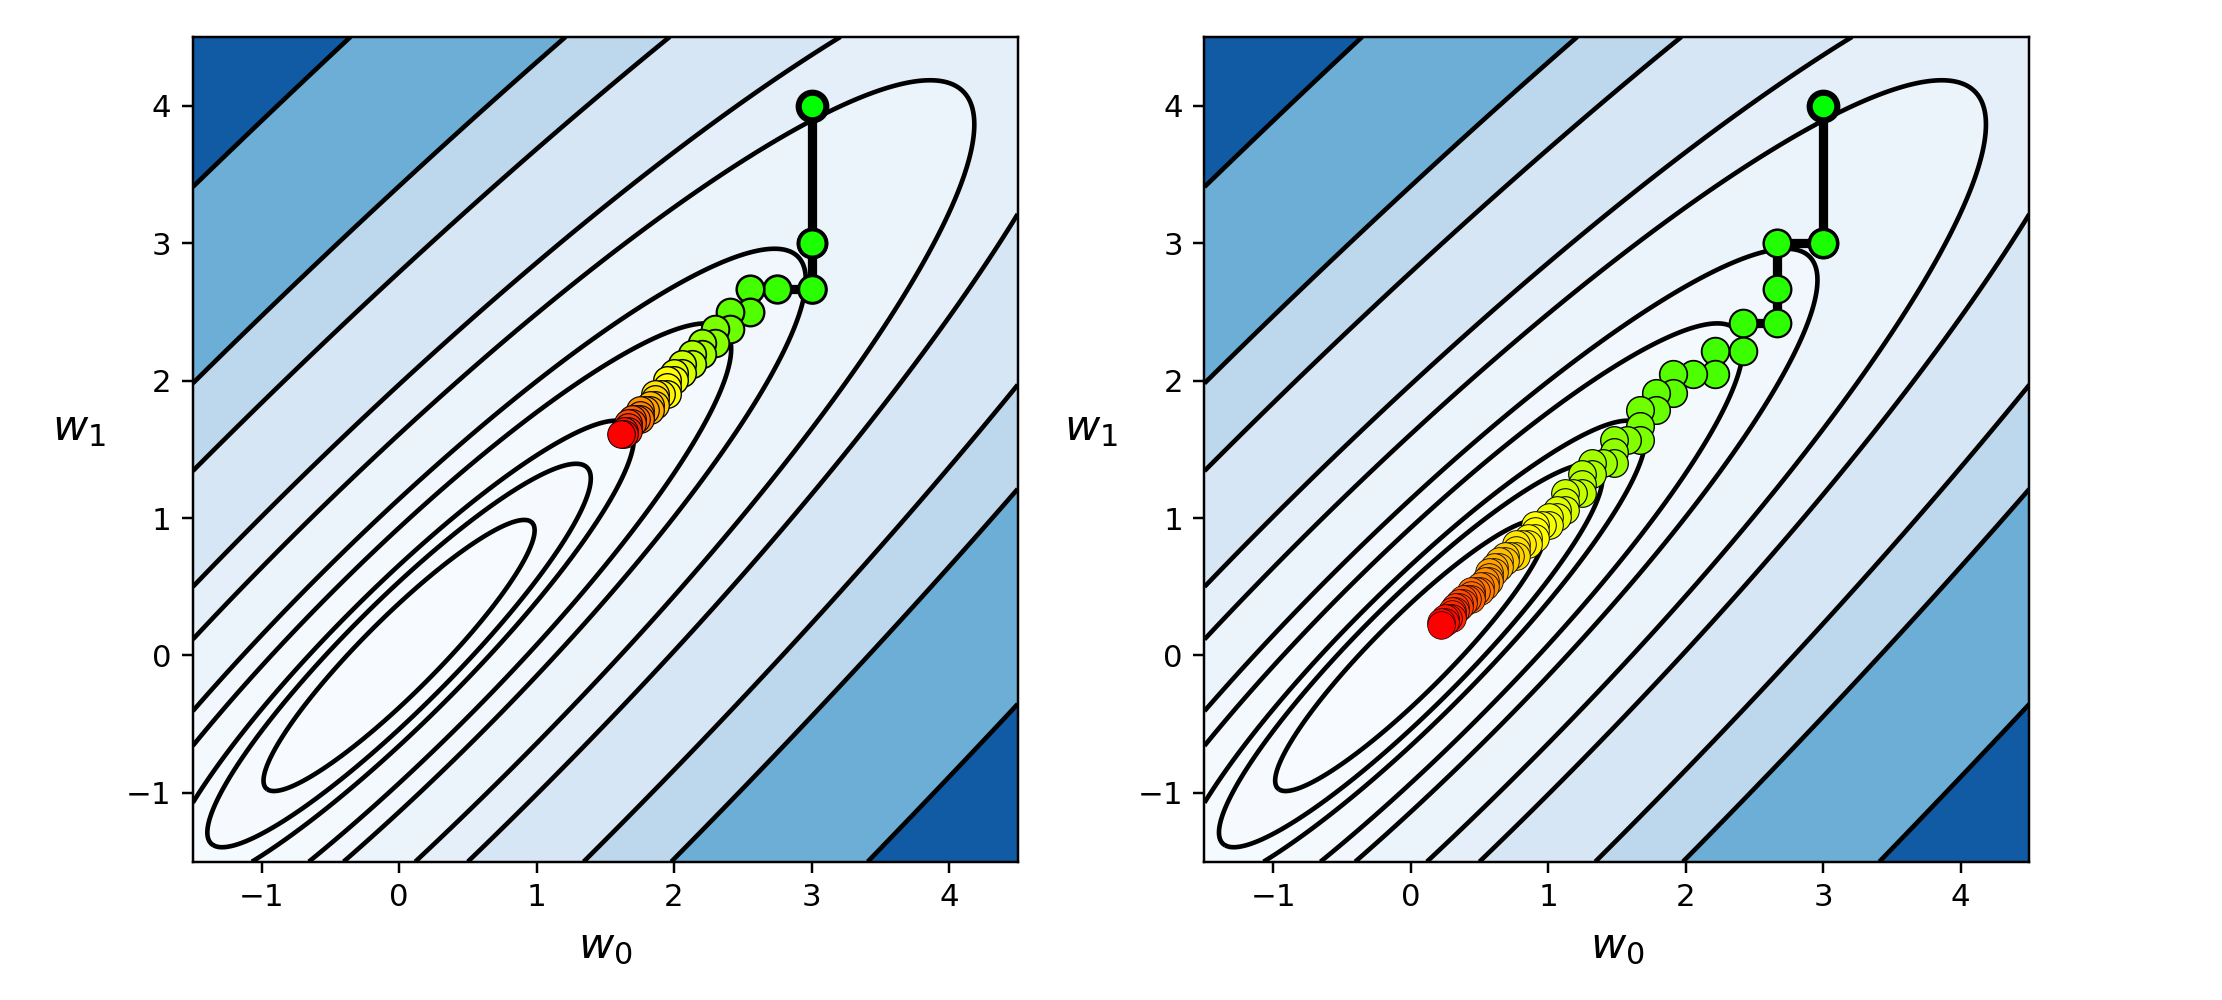

In [23]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40;
weight_history_1,cost_history_1 = coordinate_search(g,alpha_choice,max_its,w)

# run coordinate descent algorithm
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40;
weight_history_2,cost_history_2 = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 25)

We can view the precise difference more easily by comparing the two function evaluation histories via the cost function history plot, which we do below.  Here we can see in this instance while the first several steps of coordinate search were more effective than their descent counterparts (since they search over the entire list of coordinate directions instead of one at a time), the coordinate descent method quickly overtakes search finding a lower point on the cost function.

<IPython.core.display.Javascript object>


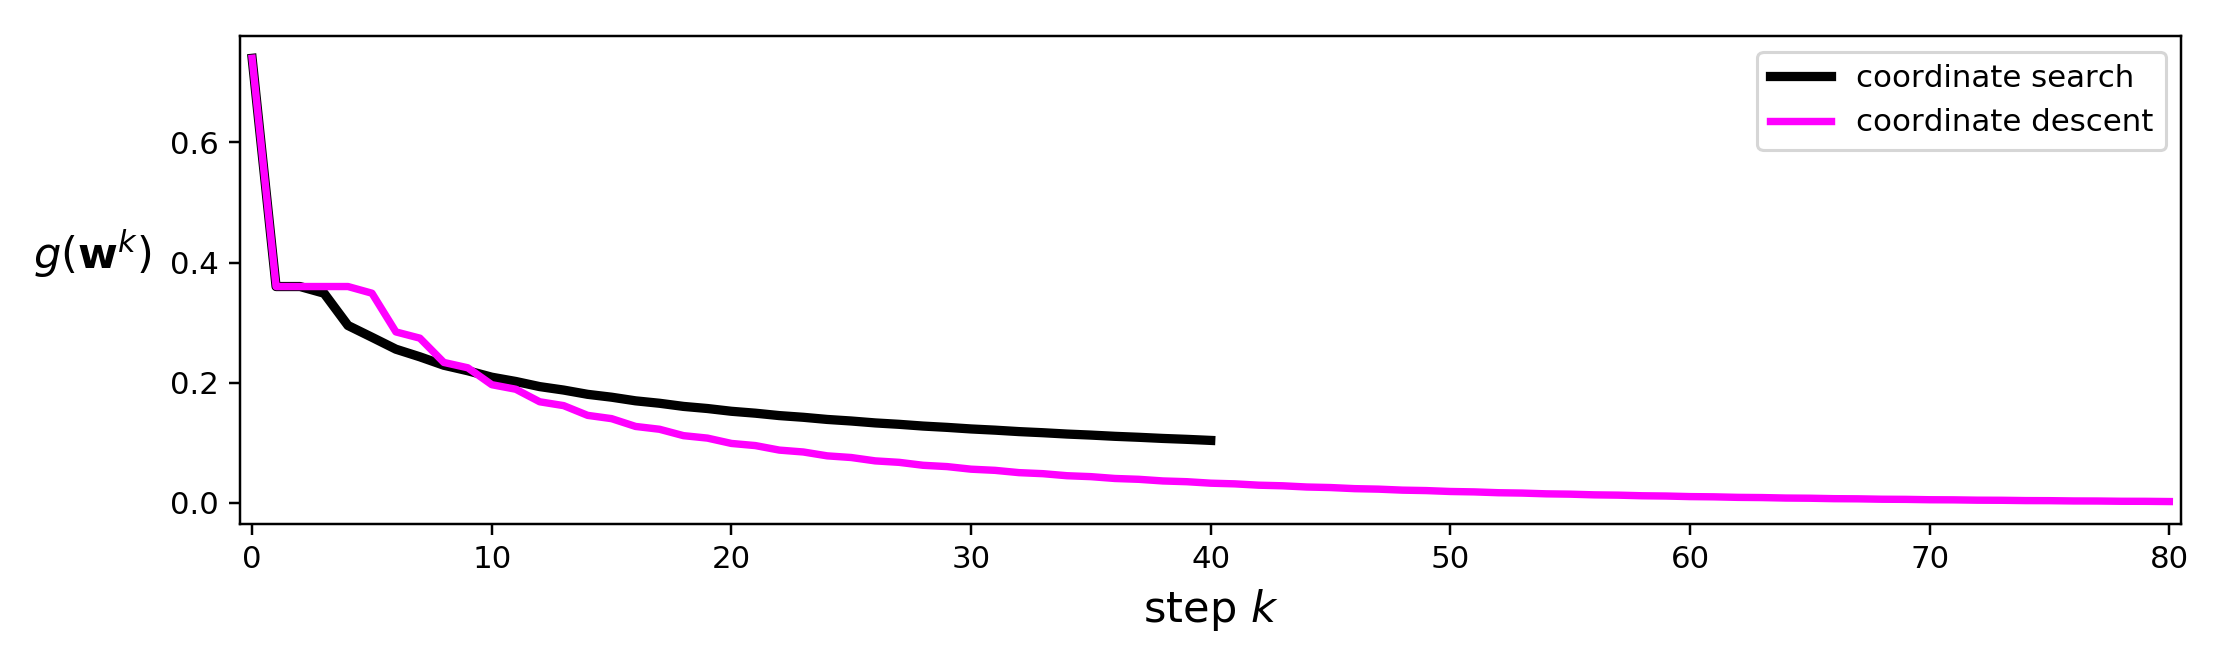

In [24]:
# This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['coordinate search','coordinate descent'])

<IPython.core.display.Javascript object>


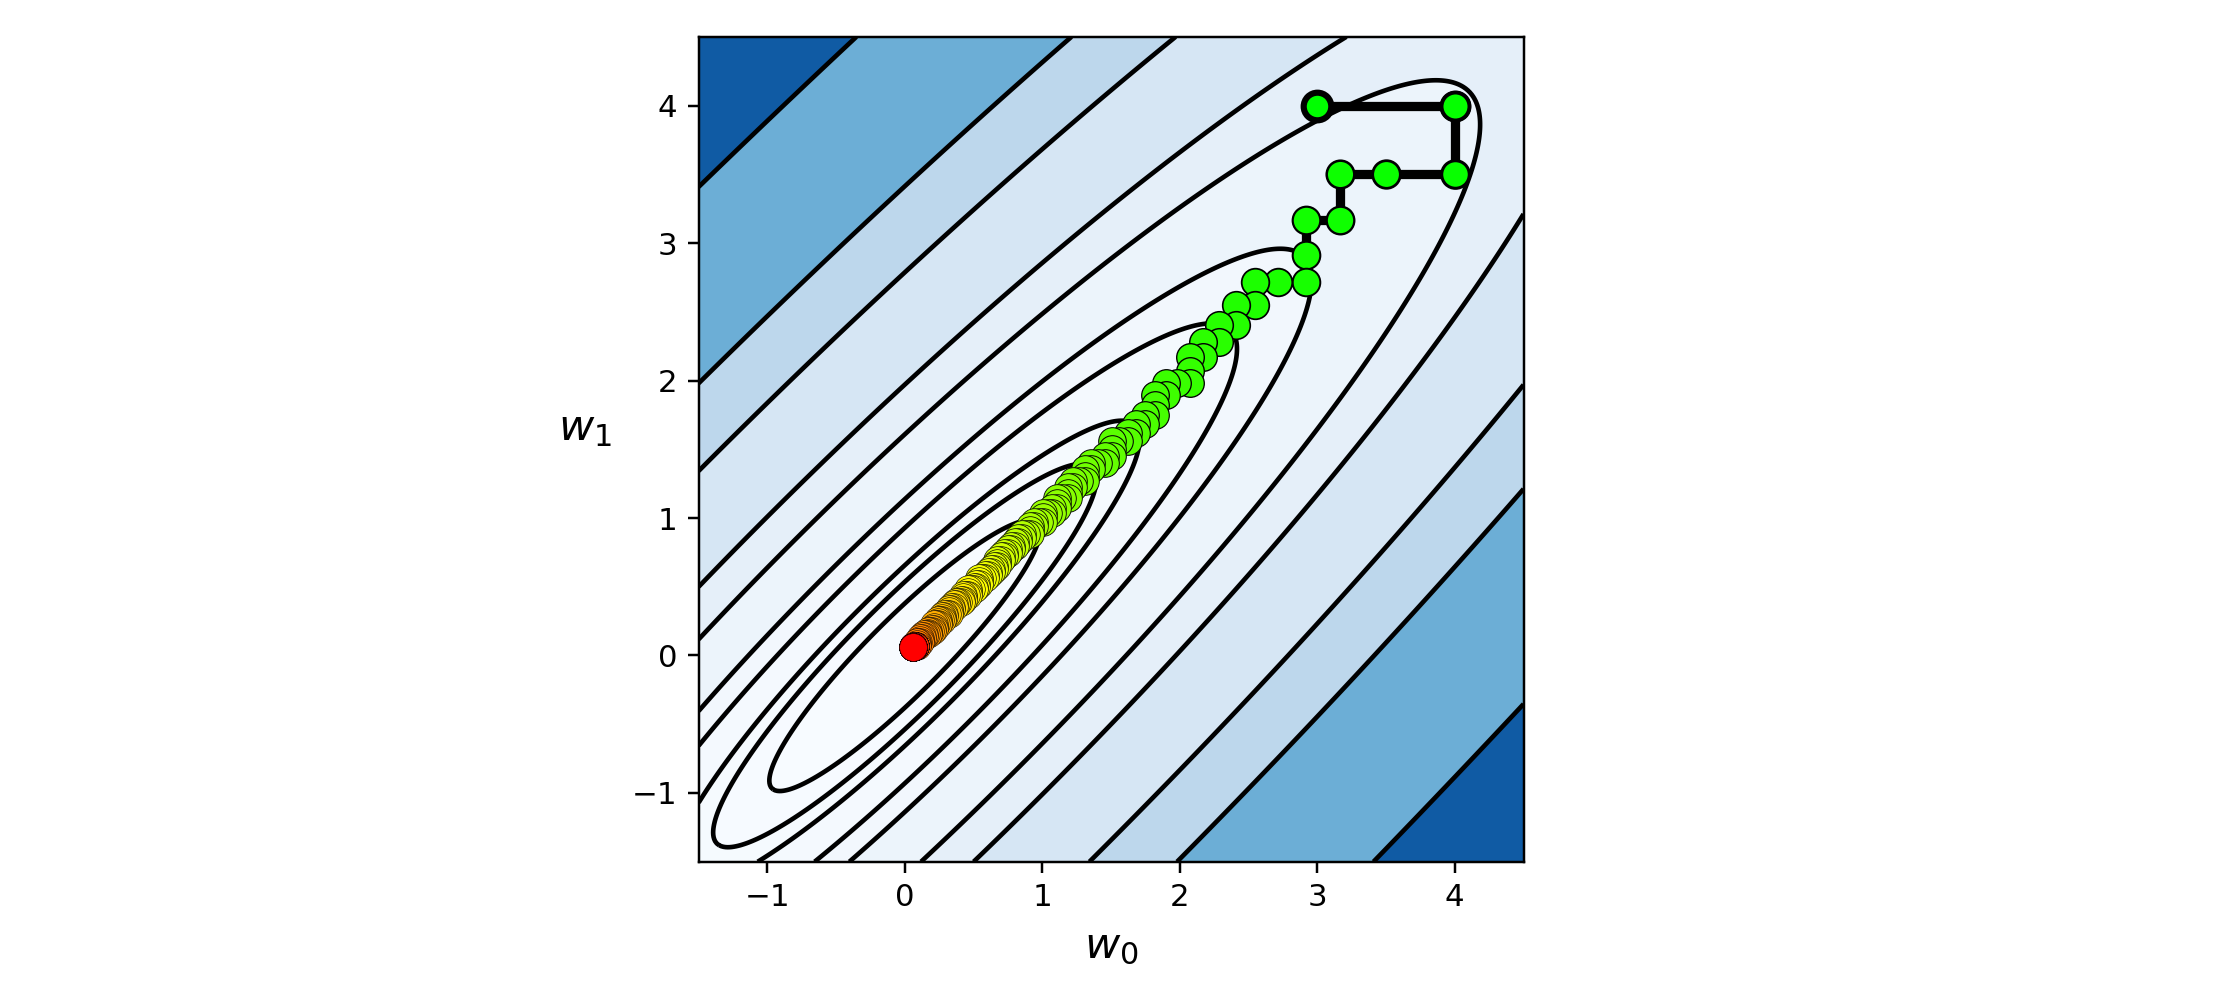

In [27]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 100;
weight_history,cost_history = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 25,show_original = False)